# Прогнозирование температуры стали во время плавки

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

Цель проекта - построить модель, которая предскажет температуру стали, и это в свою очереди позволит уменьшить потребление электроэнергии на этапе обработки стали. 

**Описание этапа обработки**  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**  
Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**План проекта**  
**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).
* Выводы

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.
* Выводы

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* корреляционный анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Константная модели.
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > нужной метрики - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

## Проведение обзора данных (EDA)

### Подготовка и анализ данных

In [1]:
!pip install seaborn lightgbm --upgrade

     |████████████████████████████████| 293 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 18.8 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.1
    Uninstalling lightgbm-3.3.1:
      Successfully uninstalled lightgbm-3.3.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from  sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV



RANDOM_STATE = 100423
CV_COUNTS = 5

In [3]:
from sklearn.model_selection import RandomizedSearchCV

**Данные об электродах**

In [4]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [7]:
len(df_arc['key'].unique())

3214

In [8]:
df_arc['Активная мощность'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

In [9]:
df_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

In [10]:
df_arc['Реактивная мощность'][df_arc['Реактивная мощность']<0].unique()

array([-715.50492418])

In [11]:
df_arc.duplicated().sum()

0

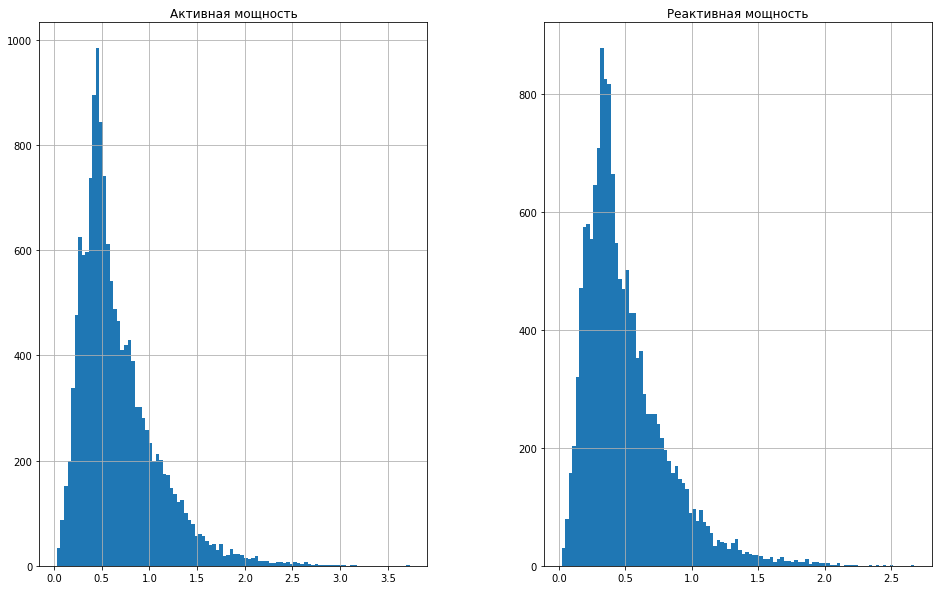

In [12]:
df_arc_no_key = df_arc.drop(columns='key')
df_arc_no_key[df_arc_no_key['Реактивная мощность'] > 0].hist(bins=100, figsize=(16,10))
plt.show()

<AxesSubplot:>

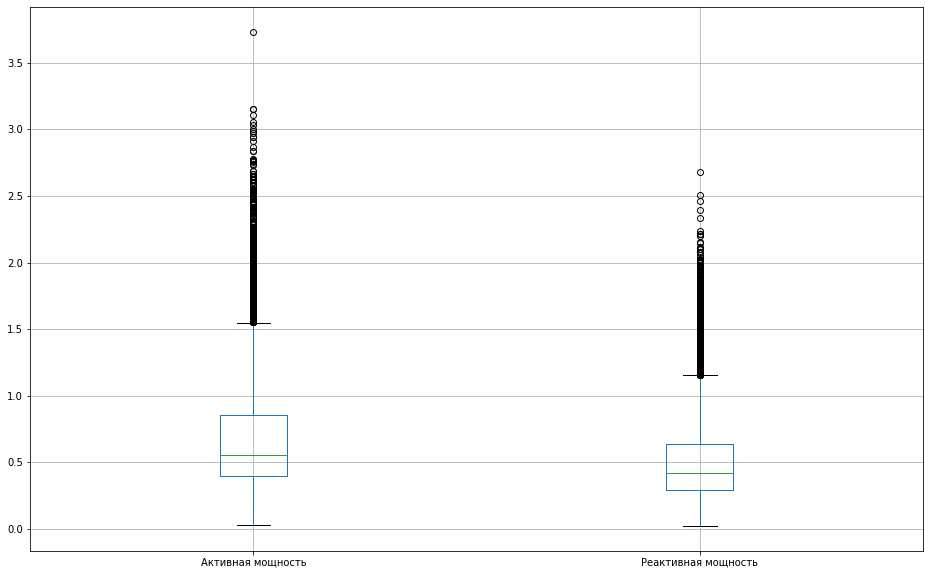

In [13]:
df_arc_no_key[df_arc_no_key['Реактивная мощность'] > 0].boxplot(figsize=(16,10))

In [14]:
len(df_arc['key'].unique())

3214

**Данные о проволочных материалах (объем)**

In [15]:
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [17]:
df_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [18]:
df_wire.duplicated().sum()

0

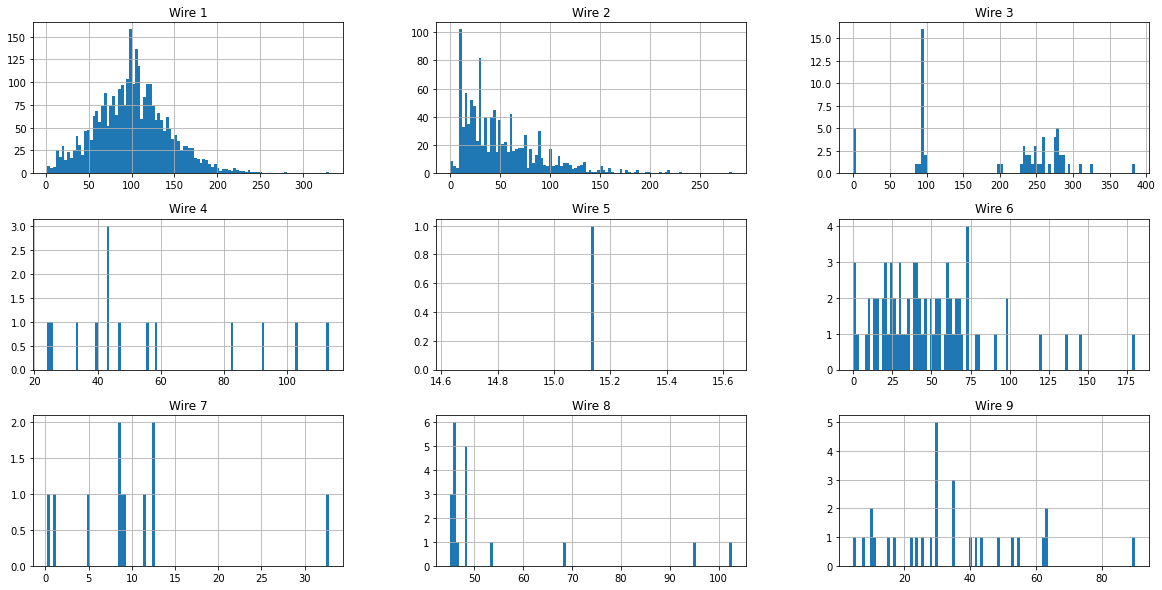

In [19]:
df_wire_no_key = df_wire.drop(columns='key')
df_wire_no_key.hist(figsize=(20, 10), bins=100)
plt.show()

In [20]:
df_wire_no_key.describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [21]:
len(df_wire['key'].unique())

3081

**Результаты измерения температуры**

In [22]:
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [23]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [24]:
df_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

In [25]:
df_temp.duplicated().sum()

0

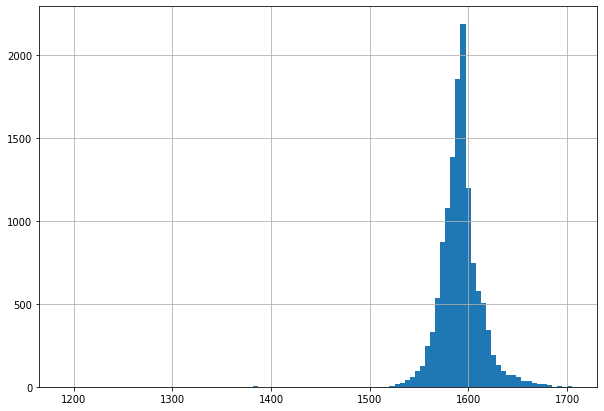

In [26]:
df_temp['Температура'].hist(bins=100, figsize=(10,7))
plt.show()

<AxesSubplot:>

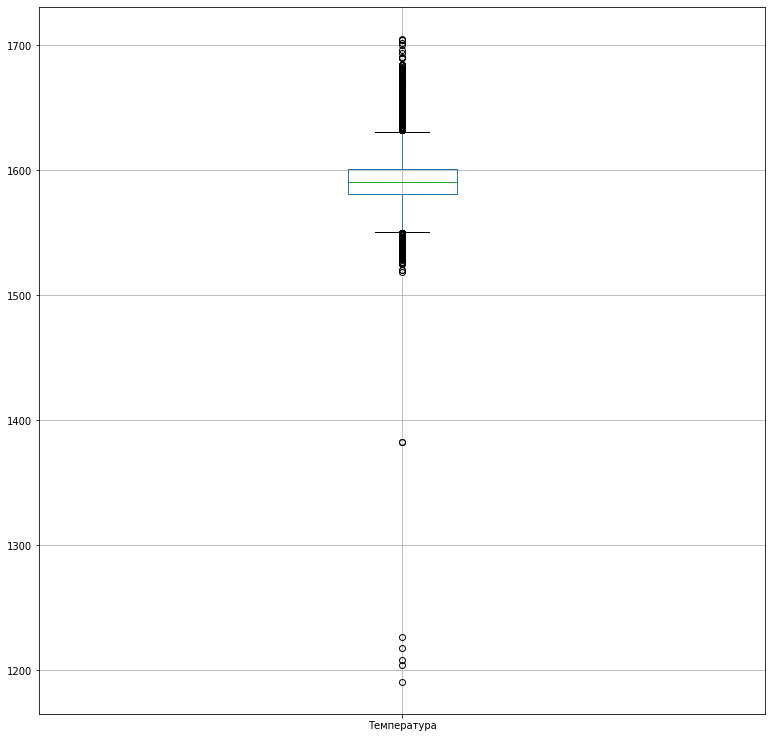

In [27]:
df_temp.boxplot(column='Температура', figsize=(13,13))

In [28]:
df_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

In [29]:
len(df_temp['key'].unique())

3216

**Данные о продувке сплава газом**

In [30]:
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [31]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [32]:
df_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

In [33]:
df_gas.duplicated().sum()

0

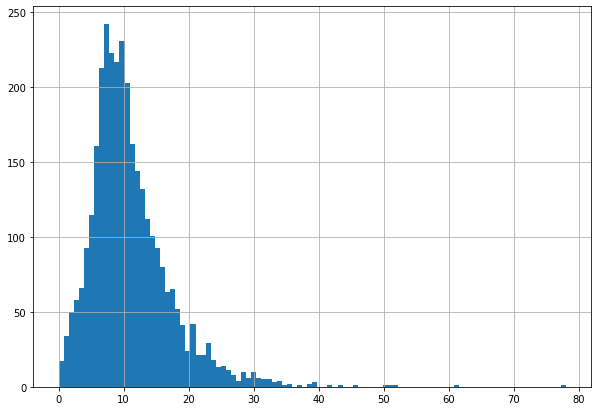

In [34]:
df_gas['Газ 1'].hist(bins=100, figsize=(10,7))
plt.show()

<AxesSubplot:>

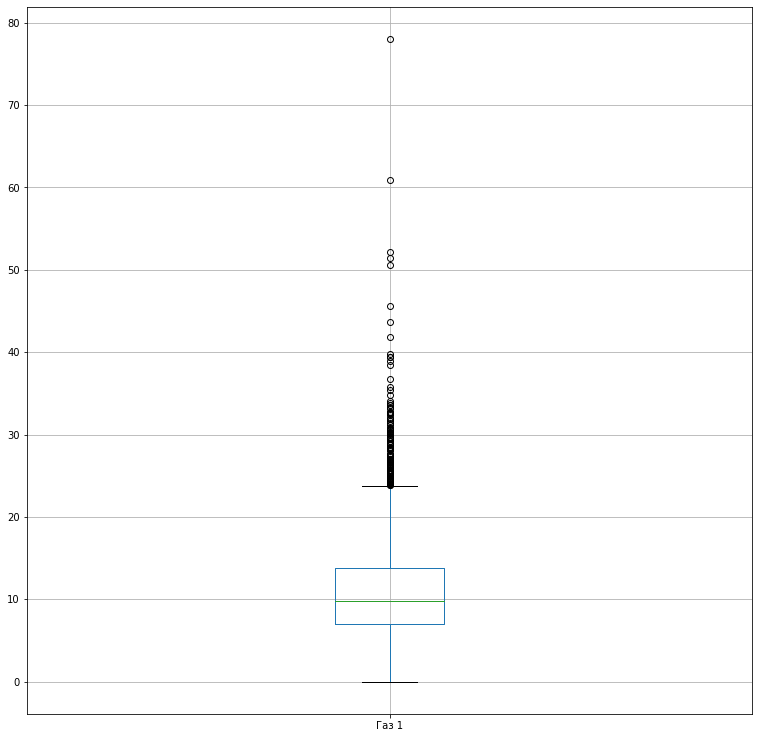

In [35]:
df_gas.boxplot(column='Газ 1', figsize=(13,13))

In [36]:
df_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [37]:
len(df_gas['key'].unique())

3239

**Данные о подаче сыпучих материалов (объем)**

In [38]:
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
display(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [39]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [40]:
df_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [41]:
df_bulk.duplicated().sum()

0

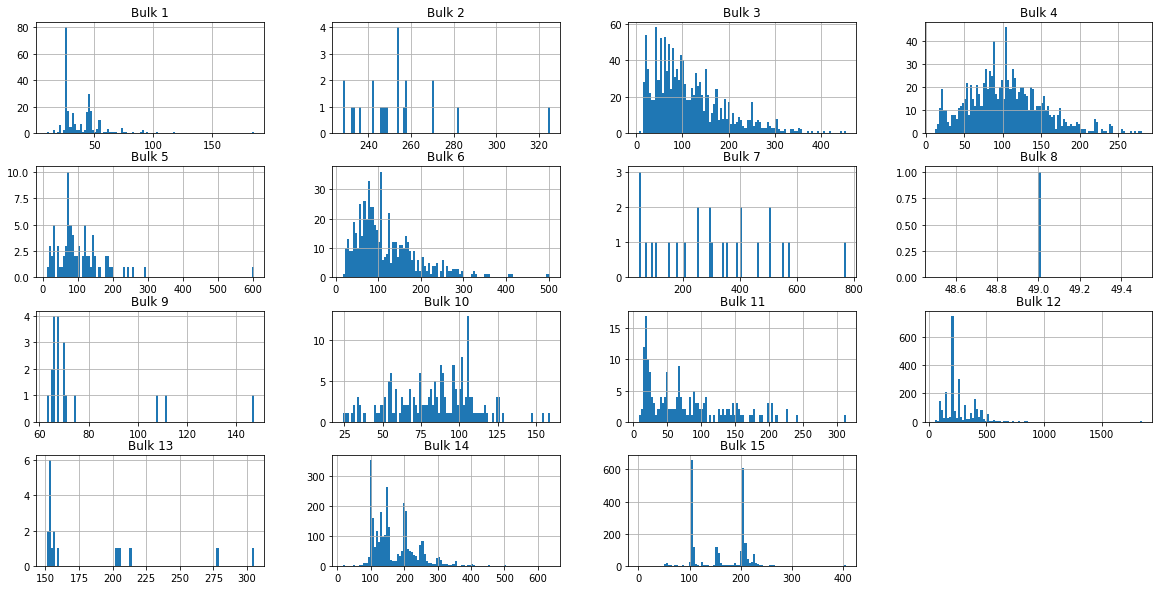

In [42]:
df_bulk_no_key = df_bulk.drop(columns='key')
df_bulk_no_key.hist(figsize=(20, 10), bins=100)
plt.show()


In [43]:
df_bulk_no_key.describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [44]:
len(df_bulk['key'].unique())

3129

**Данные о проволочных материалах (время)**

In [46]:
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [48]:
df_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [49]:
df_wire_time.duplicated().sum()

0

In [50]:
len(df_wire_time['key'].unique())

3081

**Данные о подаче сыпучих материалов (время)**

In [51]:
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [52]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [53]:
df_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [55]:
df_bulk_time.duplicated().sum()

0

In [56]:
len(df_bulk_time['key'].unique())

3129

**Вывод по первичному анализу данных**  
1. Данные об активной и реактивной мощности судя по графикам имеют нормальное распределение со смещением влево (распределение Пуассона). Также данные о продувке сплава газом на графике распределены нормально немного со смещением влево. Данные о температуре распределены нормально без смещения.  
2. Имеютмя пропуски в данных о: проволочных материалах (объем и время), измерения температуры, подаче сыпучих материалов (объем и время). Отсутствие тех или иных данных можно объяснить тем, что либо произошла какая то техническая ошибка с датчиком, который не передал значение, либо просто не было выполнен замер на какой либо стадии. В таблицах о подаче сыпучих и проволочных материалов, мы имеем 15 и 9 столбцов соответственно. На стадии легирования стали, когда изменяется ее состав, нужно разное количество материалов из таблиц `df_bulk` и `df_wire` и только единичным партиям надо использование всех возможных материалов.   
3. Выбросы. Есть аномальное значение в столбце "Реактивная мощность" равное -715. Оно похоже на ошибочное значение и его можно удалить. Построили диаграммы размаха и увидели, что в данных `df_arc`, `df_temp`, `df_gas` есть выбросы. Возможно при составлении единой таблицы для обучения моделей, нужно будет удалить эти выбросы. После встречи с тимлидом обозначили, что лучше всего удалить только аномальные выбросы, а выбросы, которые мы увидели на 'ящиках с усами' - лучше оставить без изменения, т.к. это реальнные данные измерений датчиком.
4. "Косяки" и как их исправить.   
    - В данных присуствует разное количество уникальных номеров партий `key`. Данные по партиям либо могут быть утеряны, либо над опеределенными партиями не выполнялся какой то технологический этап. Надо сгруппировать данные по признаку `key`.  
    - Время хранится в строке. Надо перевести в формат datetime. 
    - Значения `key` в данных `df_arc` и `df_temp` совпадают, но время действия технологической операции различается (как я поняла, сначала идет нагрев дугой, а затем через минуты 4 измеряется температура). Количество записей у одной партии для каждой таблицы различается.  

### Предобработка данных

In [57]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

Уберем аномальное значение в столбце "Реактивная мощность" равное -715.

In [58]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

Удалим выбросы в столбце `df_temp`. Ооставим данные, где температура будет выше 1500 градусов. 

In [59]:
#df_temp = df_temp[df_temp['Температура'] <= 1500]

key_1500 = df_temp[df_temp['Температура'] <= 1500]['key'].unique()
df_temp = df_temp[~df_temp['key'].isin(key_1500)]
#df_temp = df_temp.reset_index(drop=True)
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [60]:
df_temp['Температура'].describe()

count    12961.000000
mean      1591.956176
std         19.786049
min       1519.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

Удалим ковши, где есть только промежуточные замеры и где нет финишного замера температуры.

In [61]:
def temp_start_finish(data):
    data_temp_sorted = pd.DataFrame()
    for key in data['key'].unique():
        sorted = data[data['key']==key].sort_values(by='Время замера')
        data_temp_sorted = data_temp_sorted.append(sorted.head(1))
        data_temp_sorted = data_temp_sorted.append(sorted.tail(1))
    return data_temp_sorted

df_temp = temp_start_finish(df_temp)

df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
10,2,2019-05-03 11:59:12,1602.0
11,3,2019-05-03 12:13:17,1596.0
...,...,...,...
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0


In [62]:
key_NaN = df_temp[df_temp['Температура'].isna()]['key'].unique()
df_temp = df_temp[~df_temp['key'].isin(key_NaN)]
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
10,2,2019-05-03 11:59:12,1602.0
11,3,2019-05-03 12:13:17,1596.0
...,...,...,...
12258,2497,2019-08-06 01:53:50,1589.0
12259,2498,2019-08-06 02:03:49,1591.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0


In [63]:
len(df_temp['key'].unique())

2472

Конечная температура - наш целевой признак, сохраним в отдельный сталбец. Начальну температуру также сохпаним в отдельный столбец. Рассчитаем время между первым и последним замером температуры, тоже сохраним в отдельный столбец в секундах.

In [64]:
def delta_temp(data):
    list = []
    
    for key in data['key'].unique():
        x = data[data['key']==key].reset_index(drop=True)
        start_temp = x.loc[0,'Температура']
        finish_temp = x.loc[1,'Температура']
        delta_temp = (x.loc[1,'Время замера'] - x.loc[0,'Время замера']).seconds

        list.append([key, start_temp, finish_temp, delta_temp])
    
    return pd.DataFrame(list,
                        columns=['key',
                                 'Начальная t',
                                 'Конечная t',
                                 'Время между замерами'])

df_temp = delta_temp(df_temp)
df_temp

,key,Начальная t,Конечная t,Время между замерами
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762
...,...,...,...,...
2467,2495,1570.0,1591.0,1137
2468,2496,1554.0,1591.0,1618
2469,2497,1571.0,1589.0,717
2470,2498,1591.0,1594.0,1302


In [65]:
len(df_temp['key'].unique())

2472

Пропуски в `df_bulk` и `df_wire` заполним нулями.

In [66]:
df_bulk.fillna(0, inplace=True)
df_wire.fillna(0, inplace=True)

Нам нужна полная мощность, она счетается по формуле:
$$
S = \sqrt{P^{2}+Q^{2}}
$$
где: P - активная мощность
Q - реактивная мощность

Создадим переменную `t`, в которой будет храниться время нагрева.

In [68]:
df_arc['t'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
display(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,t
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0 days 00:02:37
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0 days 00:03:00
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0 days 00:03:04
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0 days 00:00:57


In [69]:
df_arc_power = df_arc.groupby('key').agg(t = ('t', 'sum'), P = ('Активная мощность', 'sum'), Q = ('Реактивная мощность', 'sum'))
df_arc_power['S'] = np.sqrt(df_arc_power['P']**2 + df_arc_power['Q']**2)
display(df_arc_power)

,t,P,Q,S
key,,,,
1,0 days 00:18:18,4.878147,3.183241,5.824889
2,0 days 00:13:31,3.052598,1.998112,3.648398
3,0 days 00:10:55,2.525882,1.599076,2.989502
4,0 days 00:12:21,3.209250,2.060298,3.813674
5,0 days 00:14:29,3.347173,2.252643,4.034596
...,...,...,...,...
3237,0 days 00:15:09,3.932467,2.828459,4.844014
3238,0 days 00:09:06,2.106529,1.681182,2.695151
3239,0 days 00:20:16,4.666754,3.111617,5.608989


Переведем время нагрева в секунды.

In [70]:
df_arc_power['t'] = df_arc_power['t'].dt.seconds

In [71]:
df_arc_power.info()
display(df_arc_power)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       3214 non-null   int64  
 1   P       3214 non-null   float64
 2   Q       3214 non-null   float64
 3   S       3214 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 125.5 KB


,t,P,Q,S
key,,,,
1,1098,4.878147,3.183241,5.824889
2,811,3.052598,1.998112,3.648398
3,655,2.525882,1.599076,2.989502
4,741,3.209250,2.060298,3.813674
5,869,3.347173,2.252643,4.034596
...,...,...,...,...
3237,909,3.932467,2.828459,4.844014
3238,546,2.106529,1.681182,2.695151
3239,1216,4.666754,3.111617,5.608989


Рассчитаем новые признаки: затрата энергии на нагрев и КПД.

In [72]:
# Затрата энергии/работы на наргрев = время нагрева электрода * активную мощность
df_arc_power['Энергия'] = df_arc_power['t'] * df_arc['Активная мощность']
df_arc_power

,t,P,Q,S,Энергия
key,,,,,
1,1098,4.878147,3.183241,5.824889,884.556574
2,811,3.052598,1.998112,3.648398,603.678739
3,655,2.525882,1.599076,2.989502,1086.882473
4,741,3.209250,2.060298,3.813674,513.331266
5,869,3.347173,2.252643,4.034596,380.677044
...,...,...,...,...,...
3237,909,3.932467,2.828459,4.844014,1100.521645
3238,546,2.106529,1.681182,2.695151,105.204973
3239,1216,4.666754,3.111617,5.608989,845.404617


In [73]:
# КПД = (активная мощность / полную) 
df_arc_power['КПД'] = (df_arc['Активная мощность'] / df_arc_power['S'])
df_arc_power

,t,P,Q,S,Энергия,КПД
key,,,,,,
1,1098,4.878147,3.183241,5.824889,884.556574,0.138304
2,811,3.052598,1.998112,3.648398,603.678739,0.204025
3,655,2.525882,1.599076,2.989502,1086.882473,0.555063
4,741,3.209250,2.060298,3.813674,513.331266,0.181650
5,869,3.347173,2.252643,4.034596,380.677044,0.108577
...,...,...,...,...,...,...
3237,909,3.932467,2.828459,4.844014,1100.521645,0.249936
3238,546,2.106529,1.681182,2.695151,105.204973,0.071493
3239,1216,4.666754,3.111617,5.608989,845.404617,0.123950


Для первого раза из таблицы `df_arc_power` оставлю такие признаки: КПД, энергия, t (время нагрева), S (полная мощность). 

In [74]:
df_arc_power = df_arc_power.groupby('key').agg(Энергия = ('Энергия', 'sum'), КПД = ('КПД', 'sum'), t = ('t', 'sum'), S =('S', 'sum'))
df_arc_power

,Энергия,КПД,t,S
key,,,,
1,884.556574,0.138304,1098,5.824889
2,603.678739,0.204025,811,3.648398
3,1086.882473,0.555063,655,2.989502
4,513.331266,0.181650,741,3.813674
5,380.677044,0.108577,869,4.034596
...,...,...,...,...
3237,1100.521645,0.249936,909,4.844014
3238,105.204973,0.071493,546,2.695151
3239,845.404617,0.123950,1216,5.608989


В итоговой общей таблице должны быть те значения `key`, которые есть во всех таблицах. Данные `df_bulk_time` и `df_wire_time`для обучения модели не информативны, их не добавляем.

Далее объединяем признаки в одну общую таблицу, для этого мы объединяем таблицы: `df_arc_power`, `df_temp`, `df_bulk` и `df_bulk`, `df_gas`. 

In [75]:
# В таблице df_arc_power возратим столбец key с индекса на столбец
df_arc_power = df_arc_power.rename_axis('key').reset_index()

In [76]:
df_finish = df_temp.merge(right=df_arc_power, how='inner', on='key')\
                .merge(right=df_bulk, how='inner', on='key')\
                .merge(right=df_gas, how='inner', on='key')\
                .merge(right=df_wire, how='inner', on='key')

display(df_finish)

,key,Начальная t,Конечная t,Время между замерами,Энергия,КПД,t,S,Bulk 1,Bulk 2,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,861,884.556574,0.138304,1098,5.824889,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1305,603.678739,0.204025,811,3.648398,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1300,1086.882473,0.555063,655,2.989502,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,388,513.331266,0.181650,741,3.813674,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,762,380.677044,0.108577,869,4.034596,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1137,647.439306,0.224704,723,3.985197,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,1618,663.377087,0.139581,940,5.055976,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,717,409.971957,0.249766,569,2.884756,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,1302,330.685437,0.106415,750,4.143362,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df_finish.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2325 non-null   int64  
 1   Начальная t           2325 non-null   float64
 2   Конечная t            2325 non-null   float64
 3   Время между замерами  2325 non-null   int64  
 4   Энергия               2325 non-null   float64
 5   КПД                   2325 non-null   float64
 6   t                     2325 non-null   int64  
 7   S                     2325 non-null   float64
 8   Bulk 1                2325 non-null   float64
 9   Bulk 2                2325 non-null   float64
 10  Bulk 3                2325 non-null   float64
 11  Bulk 4                2325 non-null   float64
 12  Bulk 5                2325 non-null   float64
 13  Bulk 6                2325 non-null   float64
 14  Bulk 7                2325 non-null   float64
 15  Bulk 8               

In [78]:
def show_unique(df):
    for column in df.columns:
        print(column)
        print(df[column].unique())    

In [79]:
show_unique(df_finish)

key
[   1    2    3 ... 2497 2498 2499]
Начальная t
[1571. 1581. 1596. 1601. 1576. 1543. 1586. 1577. 1587. 1574. 1616. 1606.
 1583. 1605. 1611. 1588. 1625. 1582. 1603. 1560. 1578. 1594. 1609. 1580.
 1613. 1567. 1602. 1564. 1584. 1585. 1593. 1608. 1600. 1538. 1607. 1565.
 1573. 1626. 1569. 1589. 1598. 1604. 1579. 1558. 1591. 1614. 1541. 1572.
 1557. 1544. 1619. 1620. 1645. 1631. 1635. 1652. 1628. 1563. 1559. 1561.
 1592. 1612. 1568. 1623. 1550. 1551. 1617. 1549. 1618. 1548. 1595. 1599.
 1553. 1597. 1566. 1570. 1644. 1624. 1643. 1590. 1562. 1575. 1640. 1637.
 1554. 1532. 1627. 1621. 1556. 1632. 1615. 1610. 1552. 1542. 1520. 1555.
 1629. 1529. 1636. 1545. 1651. 1530. 1654. 1622. 1531. 1639. 1638. 1634.
 1540. 1537. 1546. 1547. 1533. 1633. 1647. 1641. 1660. 1527. 1630. 1525.
 1535. 1642. 1536. 1539. 1519. 1526. 1534. 1658. 1649. 1650. 1528. 1646.
 1648.]
Конечная t
[1613. 1602. 1599. 1625. 1596. 1598. 1592. 1593. 1597. 1591. 1619. 1606.
 1607. 1595. 1603. 1618. 1585. 1600. 1601. 1604. 1609

Столбец `Wire 5` пустой, его можно удалить.

In [80]:
df_finish.drop(['Wire 5'],inplace=True, axis=1)

In [81]:
len(df_finish['key'].unique())

2325

In [82]:
duplicateRows = df_finish[df_finish.duplicated()]
duplicateRows

,key,Начальная t,Конечная t,Время между замерами,Энергия,КПД,t,S,Bulk 1,Bulk 2,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9


In [83]:
pd.isna(df_finish).sum()

key                     0
Начальная t             0
Конечная t              0
Время между замерами    0
Энергия                 0
КПД                     0
t                       0
S                       0
Bulk 1                  0
Bulk 2                  0
Bulk 3                  0
Bulk 4                  0
Bulk 5                  0
Bulk 6                  0
Bulk 7                  0
Bulk 8                  0
Bulk 9                  0
Bulk 10                 0
Bulk 11                 0
Bulk 12                 0
Bulk 13                 0
Bulk 14                 0
Bulk 15                 0
Газ 1                   0
Wire 1                  0
Wire 2                  0
Wire 3                  0
Wire 4                  0
Wire 6                  0
Wire 7                  0
Wire 8                  0
Wire 9                  0
dtype: int64

**Вывод по предобработке данных**  

- Добавили и расчитали новые признаки: `Энергия`, `КПД`, полная мощность `S`.  
- Как отдельные признаки в столбцы выделили: начальную температуру, конечную температуру. А так же рассчитали время нагрева и сохранили в столбец `t`.  
- Объединили столбцы по тем номерам партий/ковшов `key`, которые есть во всех таблицах. При этом не оставили пропусков в значениях. Пропуски в `df_bulk` и `df_wire` заполнили нулями.  
- Целевым признаком является конечная температура `Конечная t`, остальные столбцы будут использоваться для предсказания.

### Исследование итоговой таблицы с данными

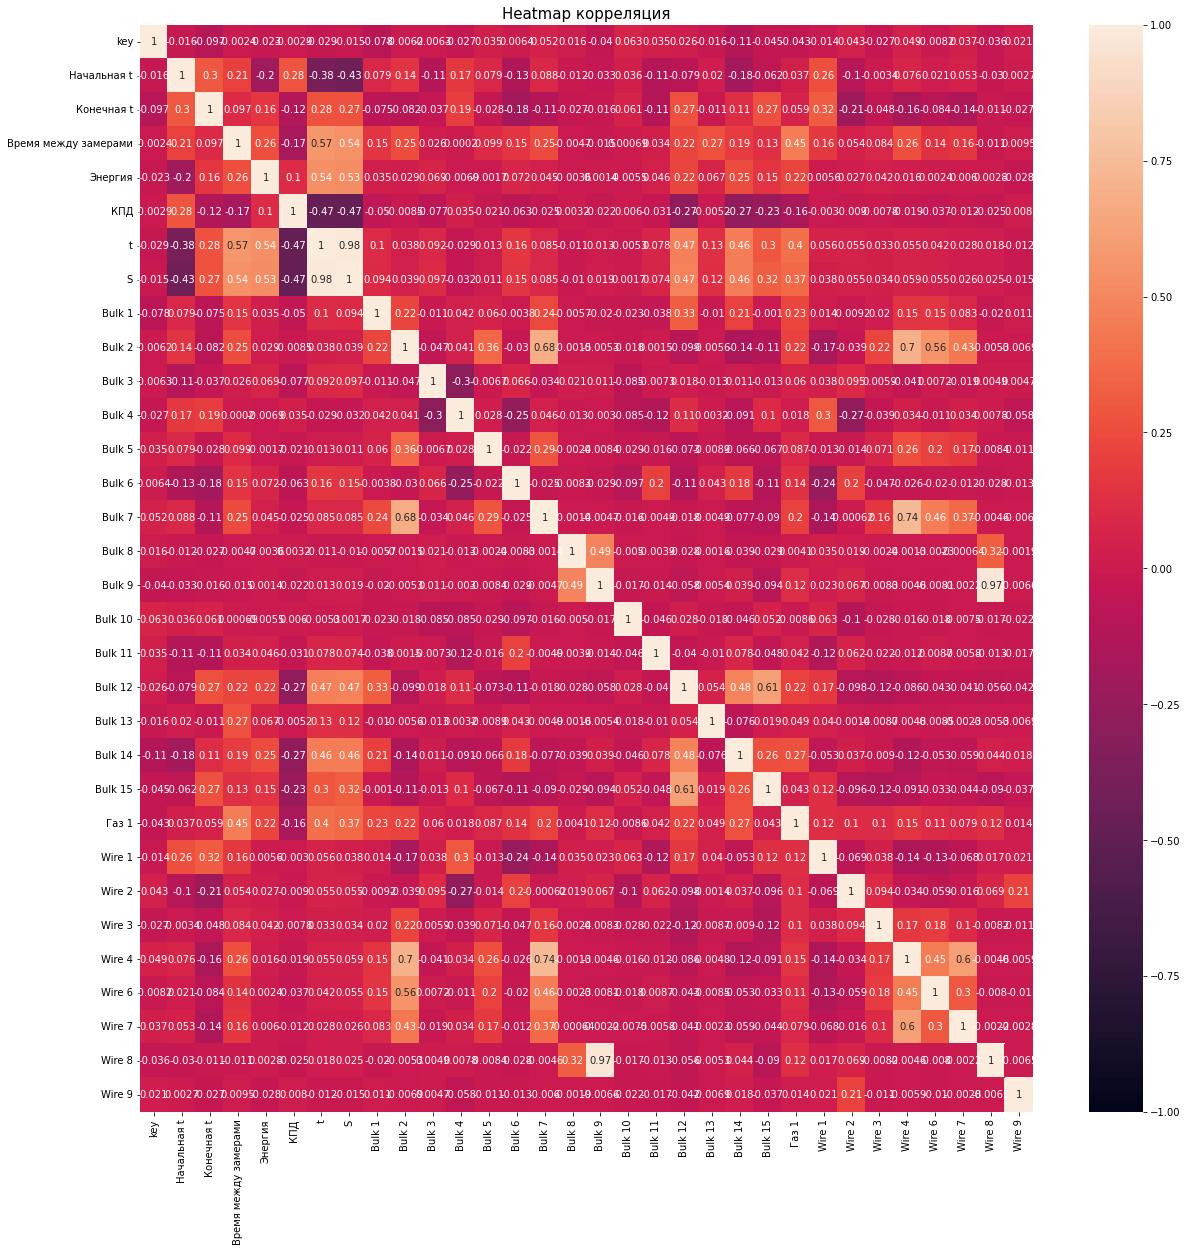

In [84]:
plt.figure(figsize=(20, 20))

heatmap = sns.heatmap(df_finish.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Heatmap корреляция', fontdict={'fontsize':15});

На тепловой карте мы видим, что у таких признаков как `S` и `t`,  `Wire 8` и `Bulk 9` - очень высокая корреляция, надо удалить один из этих признаков. 

In [89]:
df_finish = df_finish.drop(['t', 'Wire 8'], axis=1)

Рассмотрим, какие признаки влияют больше всего на таргет.

In [90]:
df_finish.corr()['Конечная t'].sort_values(ascending=False)

Конечная t              1.000000
Wire 1                  0.317702
Начальная t             0.301961
S                       0.273701
Bulk 12                 0.267379
Bulk 15                 0.266386
Bulk 4                  0.188100
Энергия                 0.160038
Bulk 14                 0.114520
Время между замерами    0.097425
Bulk 10                 0.061345
Газ 1                   0.059036
Bulk 13                -0.010925
Bulk 9                 -0.016081
Bulk 8                 -0.026590
Wire 9                 -0.027496
Bulk 5                 -0.028365
Bulk 3                 -0.036767
Wire 3                 -0.047548
Bulk 1                 -0.075233
Bulk 2                 -0.082466
Wire 6                 -0.084049
key                    -0.097052
Bulk 7                 -0.107289
Bulk 11                -0.114777
КПД                    -0.119403
Wire 7                 -0.137275
Wire 4                 -0.159737
Bulk 6                 -0.181880
Wire 2                 -0.206837
Name: Коне

Целевой признак сильнее коррелирует с:  
- `Wire 1`  
- `Начальная t`- начальная температура  
- `S`- полная мощность 
- `Bulk 12`  
- `Bulk 15`  
  
Меньше всего целевой признак связан с `Wire 2`, `Bulk 6`, `Wire 4` - отрицательная корреляция.

**Вывод по итоговой таблице**  
- Для выявления корреляций и проверки призаков на мультиколлинеарность построили тепловую карту. Выявили сильную корреляцию между такими признаками, как: `S` и `t`,  `Wire 8` и `Bulk 9`, удалили один из признаков. Сильных линейных корреляций с целевым признаком не выявлено.  
- Подготовили данные для обучения.

## Построение модели машинного обучения

### Обучение модели

Проведем разделение данных на обучающую и тестовую выборки. 

In [91]:
features = df_finish.drop(['Конечная t', 'key'], axis=1)
target = df_finish['Конечная t']
print(features.shape)
print(target.shape)

(2325, 28)
(2325,)


In [92]:
features_train, features_test, target_train, target_test = train_test_split(
                                                             features, 
                                                             target, 
                                                             test_size=.25, 
                                                             #shuffle=True,
                                                             random_state=RANDOM_STATE)  

Проведем масштабирование данных.

In [93]:
scaler = StandardScaler()
features_train_lr = pd.DataFrame(scaler.fit_transform(features_train), columns = features_test.columns)
features_test_lr = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

**LinearRegression**

In [94]:
%%time
model_LR = LinearRegression()
cv_model_LR = (cross_val_score(
                             model_LR, 
                             features_train_lr, 
                             target_train, 
                             cv=CV_COUNTS, 
                             #random_state=RANDOM_STATE,
                             scoring='neg_mean_absolute_error').mean() * -1)

print('MAE у линейной регрессии =', cv_model_LR)

MAE у линейной регрессии = 5.86508742702793
CPU times: user 188 ms, sys: 698 ms, total: 887 ms
Wall time: 807 ms


**RandomForestRegressor**

In [95]:
%%time
params = {'random_state':[RANDOM_STATE],
         'max_depth': range(10, 15),
         'n_estimators':[x for x in range(100, 501, 50)],
         'criterion':['mse']}

model_RF = RandomForestRegressor()

grid_RF = GridSearchCV(model_RF, params, scoring='neg_mean_absolute_error', cv=CV_COUNTS)
grid_RF.fit(features_train, target_train)
rf_best_paramms = grid_RF.best_params_

#print(rf_best_paramms)
print(grid_RF.best_score_)
print(grid_RF.best_estimator_)

-5.912430340569027
RandomForestRegressor(max_depth=13, n_estimators=400, random_state=100423)
CPU times: user 11min 15s, sys: 2.13 s, total: 11min 18s
Wall time: 11min 21s


In [96]:
grid_RF.best_score_ = grid_RF.best_score_ * (-1)
print('MAE у случайного леса =', grid_RF.best_score_)

MAE у случайного леса = 5.912430340569027


**CatBoostRegressor**

In [97]:
%%time
model_CB = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
cv_model_CB = (cross_val_score(
                             model_CB, 
                             features_train, 
                             target_train, 
                             cv=CV_COUNTS, 
                             scoring='neg_mean_absolute_error').mean() * -1)

best_param_CB = CatBoostRegressor(
                               verbose=False,
                               random_state=RANDOM_STATE).\
                               fit(features_train, target_train).\
                               get_all_params()

print('MAE у CatBoost =', cv_model_CB)
print(  )
print(best_param_CB)

MAE у CatBoost = 5.676160040641611

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 100423, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.04470000043511391, 'score_function': 'Cosine', 'tas

Попролбую подобрать гиперпараметры.  
Параметр 'depth' убрала, так как с ним ждала обучения час и так и не дождалась.

In [98]:
%%time
params = {'random_state':[RANDOM_STATE],
         'depth': [6,8,10],
         'learning_rate': [x/100 for x in range(1, 11)],
         'iterations': [100,1000]}

model_CB = CatBoostRegressor(verbose=False)

randm_src_CB = RandomizedSearchCV(estimator=model_CB, param_distributions=params, scoring='neg_mean_absolute_error', cv=CV_COUNTS)
randm_src_CB.fit(features_train, target_train)
randm_src_CB_best_paramms = randm_src_CB.best_params_

print(randm_src_CB_best_paramms)
print(randm_src_CB.best_score_)
print(randm_src_CB.best_estimator_)

{'random_state': 100423, 'learning_rate': 0.03, 'iterations': 1000, 'depth': 6}
-5.605542407913107
CPU times: user 6min 50s, sys: 3.92 s, total: 6min 54s
Wall time: 8min 3s


In [99]:
randm_src_CB.best_score_ = randm_src_CB.best_score_ * (-1)
print('MAE у CatBoostRegressor =', randm_src_CB.best_score_)

MAE у CatBoostRegressor = 5.605542407913107


**LightGBM Regressor**

In [100]:
%%time
params = {'random_state':[RANDOM_STATE],
         'num_leaves': range(10, 20),
          'num_leaves': [x for x in range(10,31)],
         'learning_rate': [x/100 for x in range(1, 11)]}

model_LGMB = LGBMRegressor()

randm_src_LGMB = RandomizedSearchCV(estimator=model_LGMB, param_distributions=params, scoring='neg_mean_absolute_error', cv=CV_COUNTS)
randm_src_LGMB.fit(features_train, target_train)
randm_src_LGMB_best_paramms = randm_src_LGMB.best_params_

print(randm_src_LGMB.best_score_)
print(randm_src_LGMB.best_estimator_)

-5.729908517696089
LGBMRegressor(learning_rate=0.08, num_leaves=16, random_state=100423)
CPU times: user 37min 26s, sys: 21.1 s, total: 37min 47s
Wall time: 37min 59s


In [101]:
randm_src_LGMB.best_score_ = randm_src_LGMB.best_score_ * (-1)
print('MAE у LightGBM Regressor =', randm_src_LGMB.best_score_)

MAE у LightGBM Regressor = 5.729908517696089


Константная модель через DummyRegressor - проверка на вменяемость.

In [102]:
%%time 
dummy_model = DummyRegressor(strategy="mean")
scores = cross_val_score(dummy_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print('MAE:',np.mean(np.abs(scores)))

MAE: 8.0442065297096
CPU times: user 3.88 ms, sys: 8.11 ms, total: 12 ms
Wall time: 11.1 ms


Значение MAE у DummyRegressor выше, чем у моих моделей, можно считать, что модели прошли проверку на вменяемость.

Выбор лучшей модели. Построили общую таблицу всех моделей с МАЕ.

In [104]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

df = {'MAE на обучающей выборке': [cv_model_LR,
                                     grid_RF.best_score_,
                                     randm_src_CB.best_score_,
                                     randm_src_LGMB.best_score_]}

mae = pd.DataFrame(data=df, index=index)

mae.sort_values(by='MAE на обучающей выборке', ascending=True)

,MAE на обучающей выборке
CatBoostRegressor,5.605542
LGBMRegressor,5.729909
LinearRegression,5.865087
RandomForestRegressor,5.912430


**Вывод**  
- Обучили модели: линейная регрессия, RandomForestRegressor, CatBoostRegressor.   
- Сделали константую модель и проверили модель на вменяемость.  
- Лучшая модель с MAE равное 5.6 - CatBoostRegressor. 

### Проверка моделей

Тестирование лучшей модели на тестовой выборке;  
Если MAE на тестовых данных > нужной метрики - доработка модели (MAE <= 6.8)  
Анализ важности факторов

In [105]:
best_model = randm_src_CB.best_estimator_
target_predict = best_model.predict(features_test)
mae_cb_test = mean_absolute_error(target_predict, target_test)
print('MAE на тестовой выборке CatBoostRegressor =', mae_cb_test)

MAE на тестовой выборке CatBoostRegressor = 5.496006111926708


### Анализ важности факторов

In [108]:
importances = best_model.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,Начальная t,23.947338
1,S,21.947853
2,Время между замерами,9.239914
3,Wire 1,6.169044
4,Bulk 6,4.885147
5,Bulk 15,3.930263
6,Bulk 12,3.896577
7,КПД,3.881818
8,Энергия,3.643567
9,Wire 2,3.383189


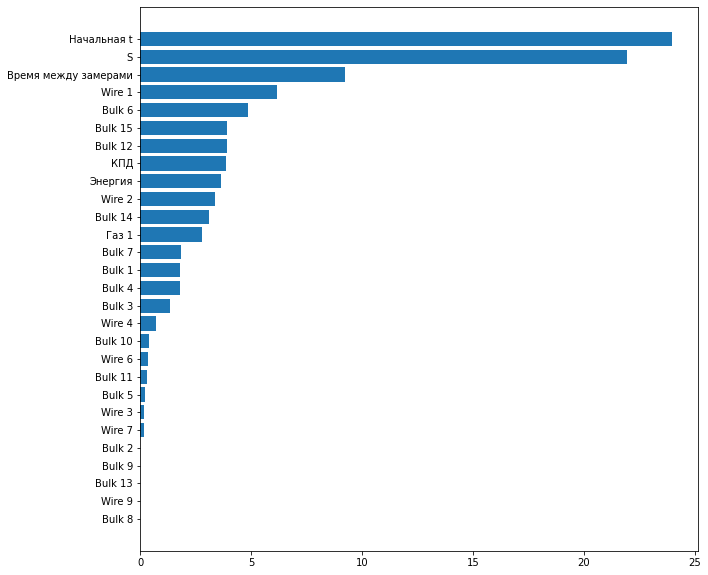

In [107]:
indices = np.argsort(importances)
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

Из графика видно, что не важные признаки для предсказания у модели: `Bulk 8`, `Wire 9`, `Bulk 13`, `Bulk 9`, `Bulk 2`. Самые значимые: `Начальная t`, `S`, `Время между замерами`, `Wire 1`, `КПД`.  
Энергия где то в середине по значимости.

## Отчёт

- Ответить на 4 вопроса:  
    - какие пункты плана были выполнены, а какие нет (поясните, почему?)
    - какие трудности возникли и как вы их преодалели?
    - какие ключевые шаги в решении задачи выполнини?
    - какая ваша итоговая модель и какое у нее качество?
- Список признаков, используемых для обучения лучшей модели и описание их преобработки.
- Гиперпараметры лучшей модели, включая random_state
- Что рекомендуете для улучшения модели, решения

**1.1.** Были выполнены почти все пункты из плана. Вот которые нет:   
    - Корректировка наименований столбцов не была проведена, т.к. в этом не было сильной необходимости.  
    - Заполнение пропусков / удаление дубликатов (при наличии), т.к. в данных не было дубликатов, а пропуски были, но их никак нельзя было заменить например медианой или средней, поэтому некоторые пропуски заполнили нулями, а какие то пришлось удалять. Причем удаляя пропуски в определенных столбцах, мы также удаляли и целую партию по "key" во всех других данных.  
    - Графический анализ у итоговой таблицы, т.к. просто сама не посчитала нужным.

**План проекта**  
**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек; ✅
* Чтение файлов и сохранение полученных данных в переменные; ✅
* Получение общей информации о таблицах (head, info, describe); ✅
* Корректировка наименований столбцов (при необходимости). ❌
* Выводы ✅

**Анализ данных:**
* Графическое представление данных из таблиц; ✅
* Проверка данных на аномалии. ✅
* Выводы ✅

**Предобработка данных:**
* Корректировка типов данных (при необходимости); ✅
* Заполнение пропусков / удаление дубликатов (при наличии); ❌
* Выделение признаков и таргета; ✅
* Соединение таблиц. ✅
* Выводы ✅

**Исследование итоговой таблицы с данными:**
* Аналитический анализ ✅
* корреляционный анализ ✅
* выводы ✅

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки; ✅
* Масштабирование данных; ✅
* Обучение модели линейной регрессии; ✅
* Обучение модели градиентного бустинга с перебором гиперпараметров; ✅
* Константная модели. ✅
* Выбор лучшей модели ✅

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;✅
* Если MAE на тестовых данных > нужной метрики - доработка модели. ✅
* Анализ важности факторов ✅

**3. Общий вывод**

**1.2.** Были трудности с пониманием: самого процесса обработки стали; какие данные в итоге должны войти в проект, а какие нет; какие новые признаки можно добавлять и нужно ли вообще - на все эти вопросы ответил тимлид на первой встрече (спасибо вам 😊). Не вошли данные `data_wire_time.csv` и `data_bulk_time.csv`, т.к. для поставленной задачи они просто не информативны. Добавили новые признаки `S`- полная мощность, `КПД`, `Энергия`, `t` - время нагрева (его правда в итоге при обучении модели убрали, т.к. этот признак сильно коррелировал с другим признаком `S`). Процесс обработки стали объяснили на встрече (один ковш = одна партия = один `key` = одна строка в итоговой табличке).   

**1.3.** Ключевые шаги: предобработка признаков и составление единой таблицы (для решения задачи нам нужны были только те партии, где имелись замеры начальной и конечной температуры, поэтому ковши, у которых были только промежуточные замеры и не было финишного замера - удалялись), обучение моделей и выбор одной наилучшей (качество модели оценивали по MAE), тестирование наилучшей модели на тестовой выборке.


**1.4.** Итоговая модель - CatBoostRegressor с качеством на тестовой выборке MAE = 5.49 (по условию MAE должно получиться <= 6.8). Это означает, что модель в среднем ошибается на 5-6 градусов.
  
  
**2.** Использовали 28 признаков:  
- Начальная температура. Стоит отметить, что этот признак является самым значимым фактором для обучения модели. Этот столбец мы выделили из `df_temp` вместе с целевым признаком `Конечная t`. Также построив диаграмму размаха `df_temp` мы увидели, что имеются выбросы, поэтому оставили те партии, где температура выше или равна 1500. 
- Полная мощность `S`. Рассчитали этот признак сами используя формулу с реактивной и активной мощностью из таблицы `df_arc`. При этом при рассчете полной мощности, мы убрали аномальное значение в столбце `Реактивная мощность` равное -715. Еще при корреляционном анализе увидели, что полная мощность сильно коррелирует с другим признаком `t` - время нагрева, поэтому для обучения удалили признак `t`, оставив признак `S`.   
- Время между замерами. Также выделили из данных `df_temp` используя столбец `Время замера`. Тут меняли тип данных на datetime.
- `КПД`. Рассчитывали поделив акивную мощность на полную. 
- `Энергия`. Затрата энергии/работы на наргрев рассчитывали умножив время нагрева электрода на активную мощность. Время нагрева рассчитали вычев в `df_arc` из `Конец нагрева дугой` `Начало нагрева дугой`.
- `Газ 1`. Оставили без изменений. 
- Столбцы `Wire 1` и тд до `Wire 9`, столбцы `Bulk 1` до `Bulk 15` - это данные о подаче сыпучих и проволочных материалов (объем). При корреляционном анализе увидели, что `Wire 8` и `Bulk 9` сильно коррелируют, признак `Wire 8` удалили. Также удалили столбец `Wire 5`, потому что он оказался совершенно пустым.  

И самое важный момент в составлении общей таблицы со всеми этими признаками был в том, что надо было удалить те партии, те ковши, те `key`, где в `df_temp` не было замера начальной и конечной температуры, удалили мы все эти партии из всех данных.  

**3.** Гиперпараметры лучшей модели CatBoostRegressor:  
    - 'random_state': 100423   
    - 'learning_rate': 0.03   
    - 'iterations': 1000  
    - 'depth': 6  
    
**4.** Для улучшения модели можно попробовать:  
1. Повлиять на фактор, который больше всех имеет важность в обучении модели, а это начальная температура ковша. Т.е. можно например чуть сильнее нагревать сплав в печи перед добавлением добавок.   
2. Можно сравнить между собой как работают разные бригады/смены, возможно у одних рабочих получилось прийти к нужному качеству стали быстрее, чем другой. Надо зафиксировать на каких этапах и в чем конкретно были различия у этих рабочих. В общем, зафиксировать различия у разных смен.
3. Как вы и писали выше, надо попробовать уменьшить разброс в измерениях, а точнее в температуре. Собрать новые данные, когда температура выходит за рамки, и фиксировать какая при этом была начальная температура, а какой химический состав, какой был газ, какая бригада была на смене и тд и тп. В общем, находить причины и фиксировать их, а потом на основе их придумывать регламенты и разрабатывать энергосберегательные мероприятия.